In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
y = snakemake_utils.get_dataset("polblog").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_results/polblog/'
! ls /data/sg/ashutiwa/final_results/airport/
DIRS = ['data_one/', 'data_two/', 'data_three/', 'data_four/', 'data_five/']
DATASET = 'polblog'
M = ["GCN_baseline", "GCN_r2v", "GCN_baseline_crosswalk", "GCN_r2v_crosswalk", 
     "GAT_baseline","GAT_r2v", "GAT_baseline_crosswalk", "GAT_r2v_crosswalk"]

TEST_ADJ_FILE='/data/sg/ashutiwa/final_results/polblog/data_one/polblog_test_adj.npz'
NUM_NODES=1224
k=5

data_five  data_one    data_two        roc_score.pkl
data_four  data_three  gini_score.pkl  sp_score.pkl


# distributions of positive and negative edgeswith dot product

In [4]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [5]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [6]:
EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(TEST_ADJ_FILE)
NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

selected edge_idx size: 29


# GCN ( baseline)

In [7]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gcn_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

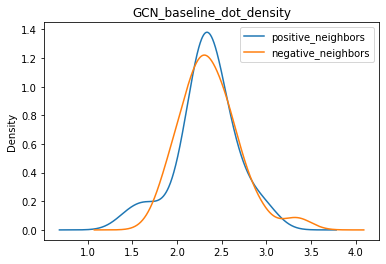

In [8]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [9]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4605.56it/s]


((6120, 2), 0.004793528736400116, 0.5041617122473246, 0.3136612516059089)

# GCN ( baseline + crosswalk)

In [10]:
model = "GCN_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_node2vec_embs.npy')
A = embs[model]
A.shape


(1224, 128)

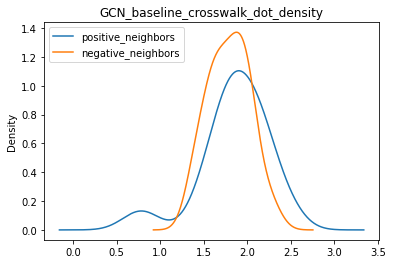

In [11]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [12]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4890.80it/s]


((6120, 2), 0.004727914139918588, 0.6040428061831153, 0.31649319881139387)

# GCN ( r2v)

In [13]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_gcn_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

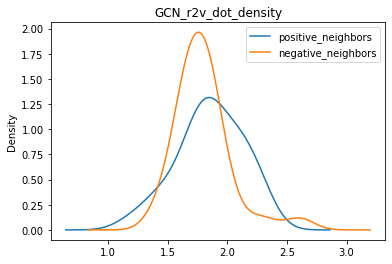

In [14]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [15]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2263.60it/s]


((6120, 2), 0.004788656839996265, 0.6135552913198573, 0.3098491299260291)

# GCN ( r2v + crosswalk)

In [16]:
model = "GCN_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_r2v_node2vec_embs.npy')
A = embs[model]

A.shape

(1224, 128)

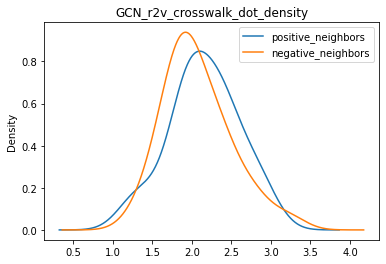

In [17]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [18]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4387.57it/s]


((6112, 2), 0.004730473081525031, 0.582639714625446, 0.3163118753932393)

# GAT ( baseline)

In [19]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_node2vec_embs.npy')
A = embs[model]

A.shape

(1224, 128)

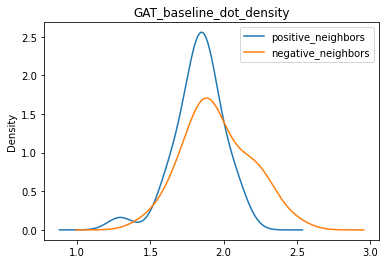

In [20]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [21]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4749.53it/s]


((6120, 2), 0.004702647482000836, 0.3365041617122473, 0.31084026057722086)

# GAT ( baseline + crosswalk)

In [22]:
model = "GAT_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

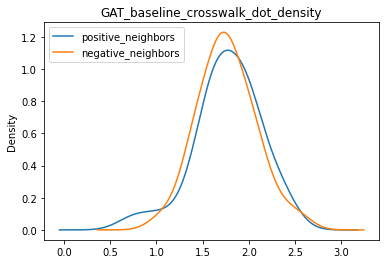

In [23]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [24]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2552.27it/s]


((6120, 2), 0.004660657828351008, 0.5303210463733651, 0.30973090307767626)

# GAT ( r2v)

In [25]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

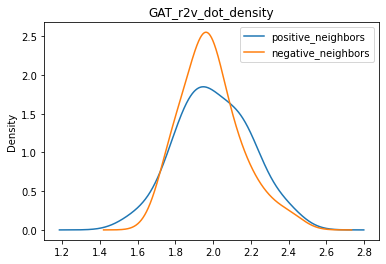

In [26]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [27]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4359.69it/s]


((6120, 2), 0.004703662255237057, 0.5338882282996433, 0.30700752690634514)

# GAT ( r2v + crosswalk)

In [28]:
model = "GAT_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(1224, 128)

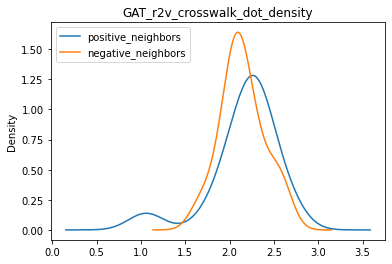

In [29]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [30]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4300.04it/s]


((6120, 2), 0.004677182815684214, 0.5969084423305588, 0.31288649424419734)

# plot statistical parity scores

# gini sp scores

GCN_baseline 0.3136612516059089
GCN_baseline_crosswalk 0.31649319881139387
GCN_r2v 0.3098491299260291
GCN_r2v_crosswalk 0.3163118753932393
GAT_baseline 0.31084026057722086
GAT_baseline_crosswalk 0.30973090307767626
GAT_r2v 0.30700752690634514
GAT_r2v_crosswalk 0.31288649424419734


Text(0.5, 1.0, 'gini statistical parity scores')

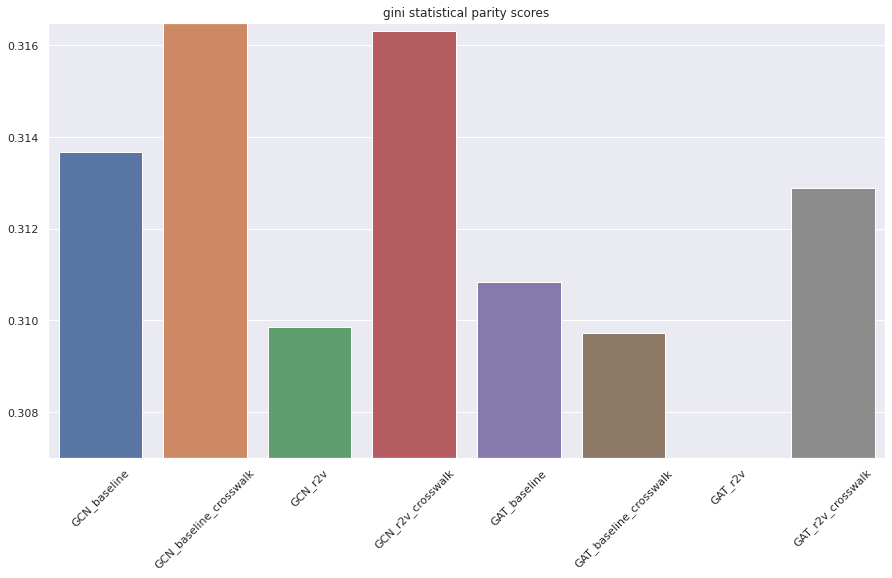

In [31]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

GCN_baseline 0.004793528736400116
GCN_baseline_crosswalk 0.004727914139918588
GCN_r2v 0.004788656839996265
GCN_r2v_crosswalk 0.004730473081525031
GAT_baseline 0.004702647482000836
GAT_baseline_crosswalk 0.004660657828351008
GAT_r2v 0.004703662255237057
GAT_r2v_crosswalk 0.004677182815684214


Text(0.5, 1.0, 'statistical parity scores')

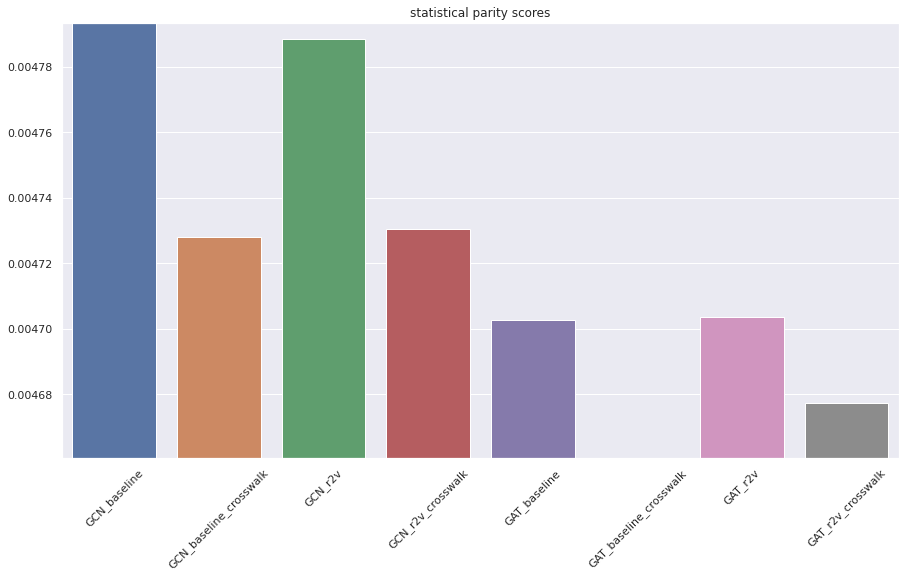

In [32]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

GCN_baseline 0.5041617122473246
GCN_baseline_crosswalk 0.6040428061831153
GCN_r2v 0.6135552913198573
GCN_r2v_crosswalk 0.582639714625446
GAT_baseline 0.3365041617122473
GAT_baseline_crosswalk 0.5303210463733651
GAT_r2v 0.5338882282996433
GAT_r2v_crosswalk 0.5969084423305588


Text(0.5, 1.0, 'roc scores')

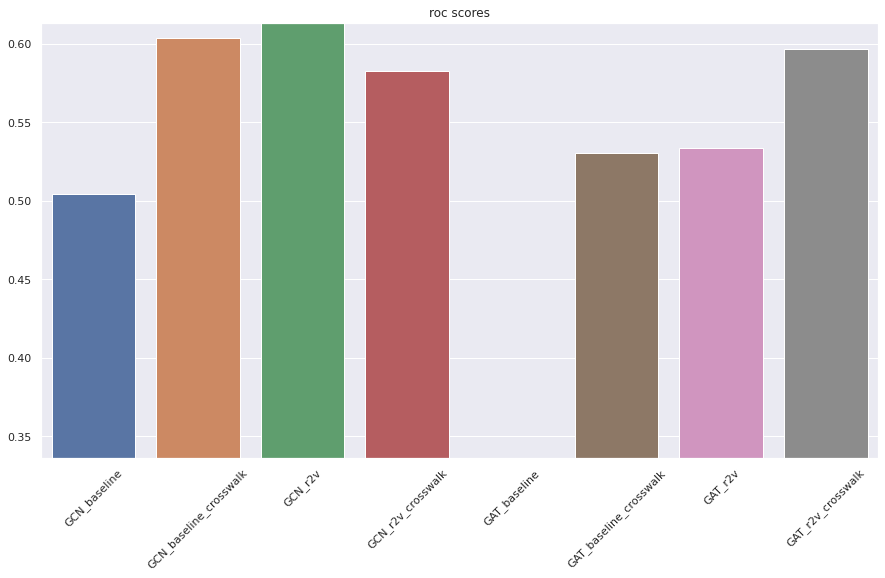

In [33]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [34]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3478.53it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3400.80it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5122.48it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4982.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3307.08it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3357.38it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4628.39it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1863.48it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4574.35it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4597.61it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2891.25it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4568.71it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3293.76it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4536.88it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3283.99it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4346.06it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4278.69it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3107.34it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2833.24it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3376.57it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

Text(0.5, 1.0, 'gini scores vs # nn')

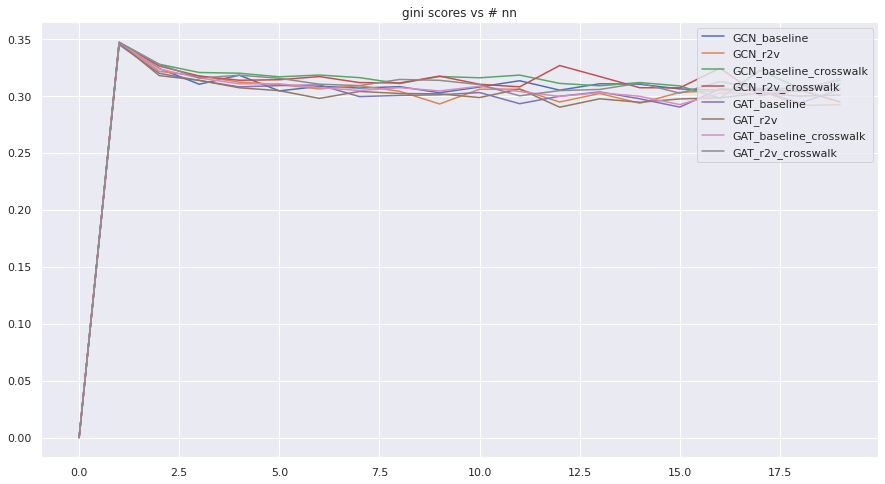

In [35]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

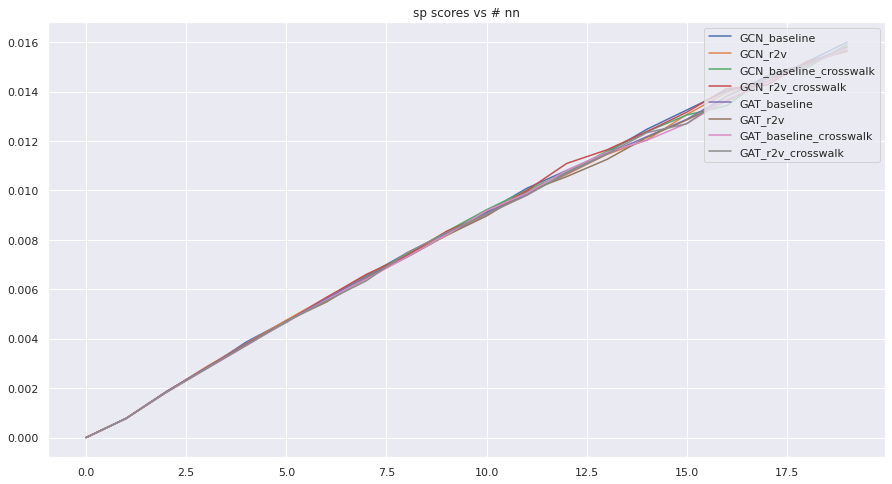

In [36]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [37]:
MODEL_NAME_2_FILE = {
    "GCN_baseline": "_gcn_node2vec_embs.npy",
    "GCN_baseline_crosswalk": "_crosswalk_gcn_node2vec_embs.npy",
    "GCN_r2v": "_gcn_r2v_node2vec_embs.npy",
    "GCN_r2v_crosswalk": '_crosswalk_gcn_r2v_node2vec_embs.npy',
    "GAT_baseline": '_gat_node2vec_embs.npy',
    "GAT_baseline_crosswalk": "_crosswalk_gat_node2vec_embs.npy",
    "GAT_r2v": "_gat_r2v_node2vec_embs.npy",
    "GAT_r2v_crosswalk": "_crosswalk_gat_r2v_node2vec_embs.npy"
}
def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        dot = create_dot_df(A)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

GCN_baseline 0.5184304399524375
GCN_baseline_crosswalk 0.6136741973840666
GCN_r2v 0.5724137931034483
GCN_r2v_crosswalk 0.6
GAT_baseline 0.4057074910820452
GAT_baseline_crosswalk 0.6249702734839477
GAT_r2v 0.5379310344827587
GAT_r2v_crosswalk 0.6324613555291319


Text(0.5, 1.0, 'roc scores')

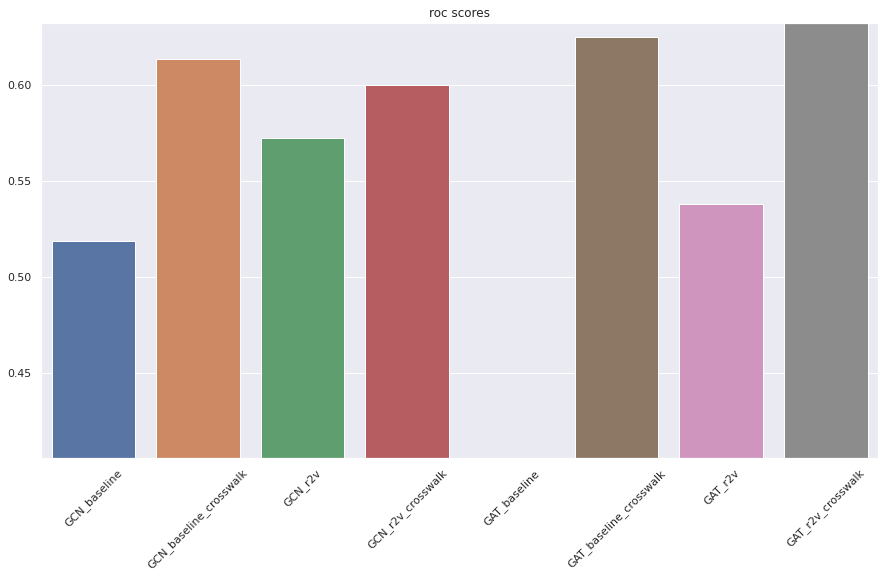

In [38]:

roc_score = {m: np.mean(roc_scores(m)) for m in MODEL_NAME_2_FILE}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3058.61it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3157.08it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2943.24it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3379.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3252.18it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3177.98it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3157.70it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3258.19it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

GCN_baseline 0.015832784204094664
GCN_baseline_crosswalk 0.015540967050774826
GCN_r2v 0.015816375534045964
GCN_r2v_crosswalk 0.015765302476224114
GAT_baseline 0.015704045534891978
GAT_baseline_crosswalk 0.015741522857825985
GAT_r2v 0.0158631031078677
GAT_r2v_crosswalk 0.01556456155434543


Text(0.5, 1.0, 'statistical parity scores')

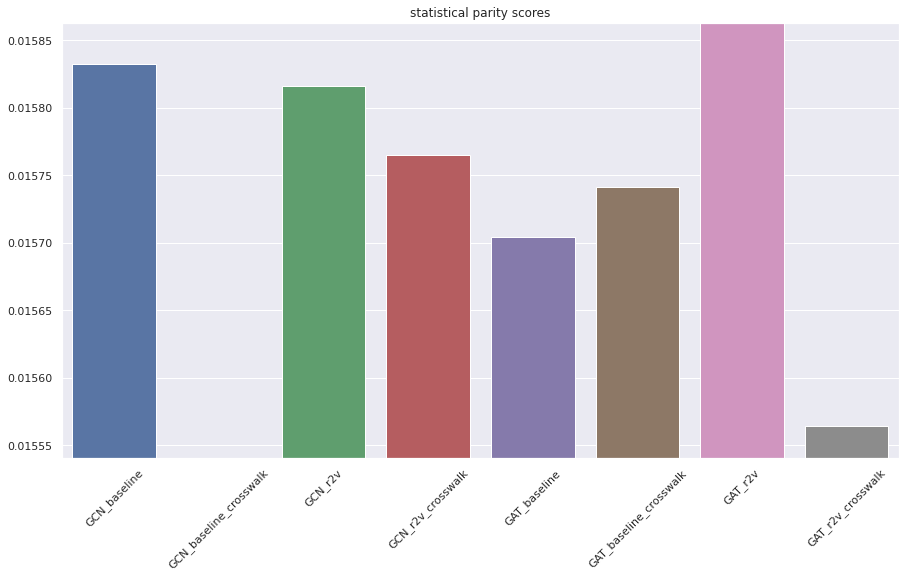

In [39]:

temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

GCN_baseline 0.3004113948904991
GCN_baseline_crosswalk 0.2984986168432858
GCN_r2v 0.3023722245850361
GCN_r2v_crosswalk 0.302987215487837
GAT_baseline 0.3018500435563576
GAT_baseline_crosswalk 0.30572080594773343
GAT_r2v 0.3034345957622467
GAT_r2v_crosswalk 0.2995681243285776


Text(0.5, 1.0, 'gini statistical parity scores')

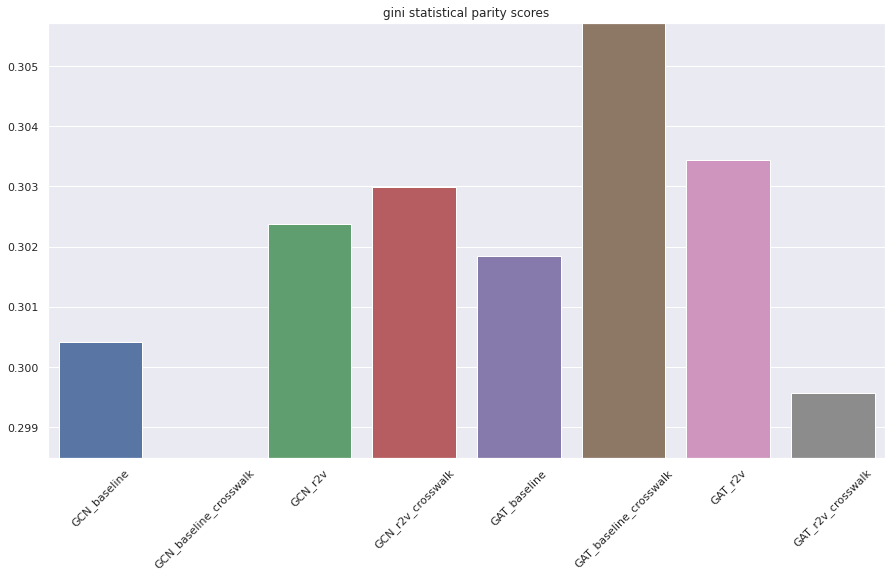

In [40]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [41]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in MODEL_NAME_2_FILE}
temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4109.35it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4194.92it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4060.57it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3602.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4100.40it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4144.50it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3093.41it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 3882.79it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training